<h1 style="color:#8B66FF;">Question 2</h1>
<h2 style="color:#659FFF;">Possion Image Blending</h2>
This algorithm is used for extracting a specific region of an image (source) and then insering that in to another image (target) where
they form a desect image without the new part being too much noticible.
<h3 style="color:#659F1F;">How it's done:</h3>
The idea is to manipulate the gradient field of image rather than image itself. Lets consider the following notation in the image bellow.
Our goal is to have
$\Delta f = \Delta g$
and also have the boundaries as same as the target. Also having their laplacian equal is same as the equation
$\Delta f = \Delta g$. Hence we start by calculating the laplacian matrix and then apply is to the images. With having the boundaries being equal, we can obtain $f$ and plug it to the target image.

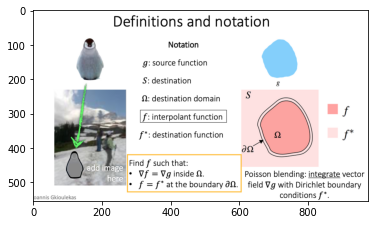

In [32]:
import matplotlib.pyplot as plt
img = plt.imread("../images/md-q3-notations.png")
plt.imshow(img)
plt.show()

Build the laplacian matrix as follows:

In [33]:
import scipy.sparse as sp
import numpy as np

def laplacian_mat(n, m):  # generate the laplacian matrix
    data, I = np.ones((m * m)), np.eye(m)
    sparse_matrix = sp.spdiags(np.array([data, -2 * data, data]), np.array([-1, 0, 1]), n, n)
    return -1 * (sp.kron(I, sparse_matrix) + sp.kron(sparse_matrix, I)).tolil()
    # convert it to lil to have more efficient calculations.

Then solve the poisson equation.

In [34]:
import cv2
from scipy.sparse.linalg import spsolve

def solve_poisson_equ(img_src, img_tar, mask, n, m):
    A = laplacian_mat(n, m)
    lap = A.tocsc()

    # since the area does not necessarily have a rectangular shape, we should set the ones outside this region to identity.
    for y in range(1, n - 1):
        for x in range(1, m - 1):
            if mask[y, x] == 0:  # so if it was in the black area, it means that we should set the row be identity.
                z = x + y * m  # meaning only the pixel in center is 1 and others are zero.
                A[z, z], A[z, z + m], A[z, z - m], A[z, z + 1], A[z, z - 1] = 1, 0, 0, 0, 0
    A = A.tocsc()
    # apply this on the images
    src_reshaped, tar_reshaped = img_src.copy().reshape((m * n, 3)), img_tar.copy().reshape((m * n, 3))
    mask = mask.flatten()
    b = lap.dot(src_reshaped)
    b[mask == 0] = tar_reshaped[mask == 0]  # the boundary
    res = spsolve(A, b).reshape((n, m, 3))  # solve the equation A f = A g
    res[res > 255], res[res < 0] = 255, 0  # make sure it is in the correct range.
    cv2.imwrite("../results/res07.jpg", res.astype('uint8'))
    return res.astype('uint8')

Now lets apply the algorithm above to some images:

In [36]:
def apply_poisson_blending(src_name, tar_name, mask_name, x_off, y_off):
    # x_off and y_off are the offsets used to move the source to the desired place in target
    img_src = cv2.imread("../images/" + src_name + ".jpg")
    print("src image :")
    plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
    plt.show()
    img_tar = cv2.imread("../images/" + tar_name + ".jpg")
    print("target image :")
    plt.imshow(cv2.cvtColor(img_tar, cv2.COLOR_BGR2RGB))
    plt.show()
    mask = cv2.imread("../images/" + mask_name + ".jpg", 0)
    print("mask image :")
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.show()
    # they don't have the same shapes so I used an affine transformation to do so
    n, m, _ = img_tar.shape
    translation_mat = np.float32([[1, 0, x_off], [0, 1, y_off]])
    img_src = cv2.warpAffine(img_src, translation_mat, (m, n))
    mask = cv2.warpAffine(mask, translation_mat, (m, n))
    # some of the pixels might be other than 0 and 255 so if it was the case, make them be 0 or 255
    mask[mask < 0.1] = 0
    return solve_poisson_equ(img_src, img_tar, mask, n, m)

src image :


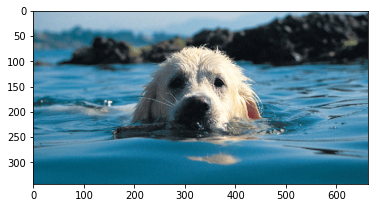

target image :


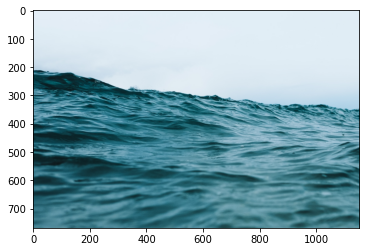

mask image :


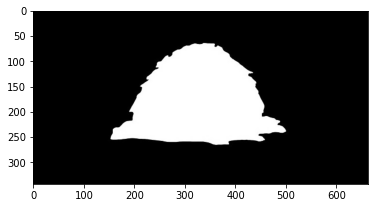

the result


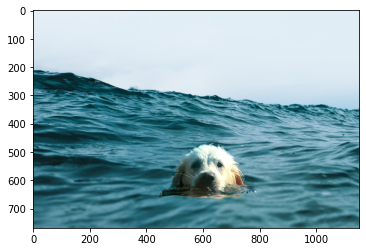

In [37]:
img = apply_poisson_blending("res05", "res06", "dog_mask", 290, 402)
print("the result")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()